In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from wallstreet import Stock
from yahoo_fin import options
from py_vollib.black_scholes import black_scholes
from py_vollib.black_scholes.implied_volatility import implied_volatility
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from datetime import datetime, timedelta
from dateutil import parser, relativedelta

import warnings
warnings.filterwarnings("ignore")

# ESPP

A typical Employee Stock Purchasing Plan (ESPP) works as follows:

The employee signs up by day $t_0$ (the offering date) when the company share price is $S(t_0)$, and agrees to contribute $x\%\in[1\%,15\%]$ of their salary (usually the contribution percentage has to be an integer value, but this does not affect this exercise).

For our purposes let's assume they get paid monthly starting at day $t$. Then $x\%$ of their salary is taken out of each monthly payslip.

6 months after the offering date on day $t_0+182$ (the purchase date), the money accumulated from contributions is used to buy shares in the employer at a $15\%$ discount of the lowest between the share price on the offering date and the share price on that day.

The next 6 months of contributions are similarly used to buy shares at $(1-0.15)\times \min\left(S(t_0), S(t_0+365)\right)$.

ESPPs vary from company to company, but they all more or less follow this basic format. For tax reasons, the amount you can contribute to an ESPP is usually limited to US$25,000 but I will ignore this complication here.

# ESPP payoffs

If the share price on a purchase date is less than or equal the share price on the offering date, then the payoff of the program is simply the $15\%$ discount on the shares. Hence someone with $\$n$ in accumulated contributions would receive:

$n\times\dfrac{1}{1-0.15}=1.1765n$

If the share price has risen between the offering date and the purchase date, then the implicit discount is:

$1-\dfrac{(1-0.15)\times S(t_0)}{S(t_0+182)}$

The payoff in this situation is:

$n\times\dfrac{S(t_0+182)}{(1-0.15)\times S(t_0)}$

Generally, the payoff for $\$n$ is:

$n\times\dfrac{\max(S(t_0+182), S(t_0))}{(1-0.15)\times S(t_0)}$

We can use this to plot the payoff of a single ESPP purchase for every dollar accumulated

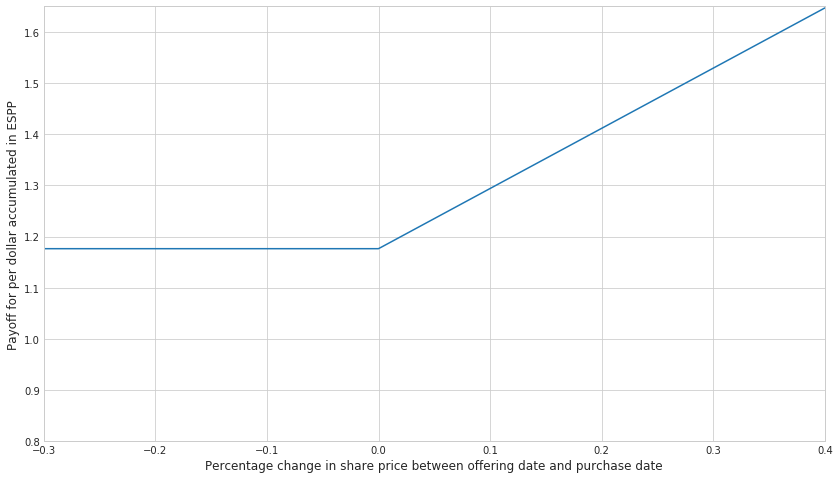

In [2]:
min_plan_discount = 0.15

#Function to get the dollar amount received from a single ESPP purchase
def espp_payoff_func(offering_date_price, purchase_date_price, dollar_amount):
    
    implicit_return = max(offering_date_price, purchase_date_price)/((1-min_plan_discount)*offering_date_price)
    
    payoff = dollar_amount*implicit_return
    
    return payoff

vespp_payoff_func = np.vectorize(espp_payoff_func)

# Relative price changes in the company's share price
price_changes = np.linspace(-0.3, 0.4, num=1000)

# Percentage return of the ESPP for various share prices on the purchase date
espp_payoff = vespp_payoff_func(1, 1+price_changes, 1)

fig = plt.figure(figsize = (14,8))
ax = plt.axes()
ax.set_xlabel('xlabel', fontsize=12)
ax.set_ylabel('ylabel', fontsize=12)

plt.plot(price_changes, espp_payoff)

plt.ylim(0.8, 1.65)
plt.xlim(-0.3, 0.4)

plt.xlabel('Percentage change in share price between offering date and purchase date')
plt.ylabel('Payoff for per dollar accumulated in ESPP');

This looks a lot like the payoff of a call option, with the small difference that instead of the maximum loss being equal to the option premium, our lowest possible payoff is the $17.65\%$ return if the share price falls between the offering and purchase date.

This suggests how we should value an ESPP.

# Decomposing an ESPP

Our strategy should be to decompose the ESPP into contracts we know how to value individually, which we can then sum up to value the ESPP as a whole.

The guaranteed $17.65\%$ return and the increasing payoff at the offering date price suggests our starting point should be to decompose an ESPP into a bond with a single coupon maturing on the purchasing date, and a call option with the offering date share price as the strike price expiring on the purchase date. Because the shares purchased come at a $15\%$ discount, we also have to gross up the value of the underlying shares in the call option by $\dfrac{1}{1-15\%}$.

In [3]:
def bond_payoff_func(bond_yield, face_value):
    return (1+bond_yield)*face_value

def call_option_payoff_func(strike_price, spot_price_expiration, dollar_amount_underlying):
    return max(0, spot_price_expiration-strike_price)*dollar_amount_underlying

vbond_payoff_func = np.vectorize(bond_payoff_func)
vcall_option_payoff_func = np.vectorize(call_option_payoff_func, otypes=[np.float])

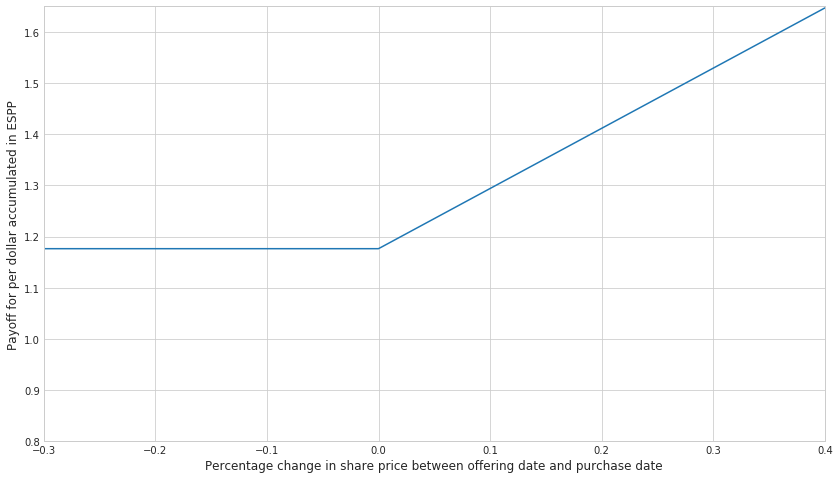

In [4]:
price_changes = np.linspace(-0.3, 0.4, num=1000)

# Percentage return of the ESPP for various share prices on the purchase date

bond_yield =  (1/(1-min_plan_discount))-1

bond_payoff = vbond_payoff_func(bond_yield, np.ones(len(price_changes)))

strike_price = 1
spot_price_expiration = (1+price_changes)*strike_price

dollar_amount_underlying = 1/(1-min_plan_discount)

option_payoff = vcall_option_payoff_func(strike_price, spot_price_expiration, dollar_amount_underlying)

total_return = bond_payoff+option_payoff

fig = plt.figure(figsize=(14,8))
ax = plt.axes()
ax.set_xlabel('xlabel', fontsize=12)
ax.set_ylabel('ylabel', fontsize=12)

plt.plot(price_changes, total_return)

plt.ylim(0.8, 1.65)
plt.xlim(-0.3, 0.4)

plt.xlabel('Percentage change in share price between offering date and purchase date')
plt.ylabel('Payoff for per dollar accumulated in ESPP');

This is identical to the payoff chart we calculated for the ESPP. We are on the right track.

## Valuing the bond component

The present value of a bond are the discounted expected future cashflows, and in this case there is only one future cashflow (the coupon and face value at maturity). This works like a T-bill but I will continue to use the term bond as it is conventional when talking about debt with private companies.

The expected part is a bit trickier, since technically we should account for the risk of the company defaulting on its ESPP obligations and the risk of the employee leaving the company for whatever reason (in which case the employee would usually receive their contributions back without interest). For simplicity sake, I will use the risk-free rate as measured by the US yield curve, which as of May 21 2020 was $0.16\%$. You can see the latest Tresury rates from [the US Treasury website](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yield).

In [5]:
risk_free_rate = 0.16/100

def get_bond_component_value(espp_funds_accumulated, min_plan_discount, time_to_maturity, discount_rate):
    
    daily_discount_rate = (1+discount_rate)**(1/365)-1
    
    discount = (1+daily_discount_rate)**(time_to_maturity*365)
    
    return (espp_funds_accumulated/(1-min_plan_discount))/discount

## Valuing the option component

To value the option component we will use the famous Black-Scholes equation. Rather than reinvent the Nobel prize winning wheel, I use the popular [py_vollib library](http://vollib.org/documentation/python/1.0.2/index.html).

The one thing to note here is that it does not matter what the underlying share price is to get the value of the option.

In [6]:
def get_option_component_value(espp_funds_accumulated, min_plan_discount, time_to_option_expiry, discount_rate, volatility):
    
    underlying_share_amount = espp_funds_accumulated/(1-min_plan_discount)
    
    cp_flag = 'c' # Call option
    
    spot_price = 1
    strike_price = spot_price
    
    opt_price = black_scholes(cp_flag, spot_price, strike_price, time_to_option_expiry, discount_rate, volatility)\
                *underlying_share_amount
    
    return opt_price

## Putting it all together

In [7]:
def espp_contract_value(espp_funds_accumulated, min_plan_discount, time_to_maturity\
                        , time_to_option_expiry, discount_rate, volatility):
    
    bond_component_value = get_bond_component_value(espp_funds_accumulated, min_plan_discount\
                                                    , time_to_maturity, discount_rate)
    
    option_component_value = get_option_component_value(espp_funds_accumulated, min_plan_discount\
                                                        , time_to_option_expiry, discount_rate, volatility)
    
    espp_value = bond_component_value + option_component_value
    
    return espp_value

Let's start with a simple example, where there is only one contribution on January 1, 2020 (the offering date) and shares are purchased six months later on July 1, 2020. To calculate the option component value we need volatility for the underlying. Later we will use some real-life volatilities, but for now let's use $\sigma=0.5$

For reasons that will become clear later, I have separated the time to maturity of the bond component and time to expiry of the option component, even though they are the same here.

In [8]:
espp_funds_accumulated = 1
min_plan_discount = 0.15

offering_date = datetime(2020,1,1)
purchase_date = datetime(2020,7,1)

time_to_purchase_date = (purchase_date-offering_date).days/365

time_to_option_expiry = time_to_purchase_date

volatility = 0.5

espp_contract_value(espp_funds_accumulated, min_plan_discount, time_to_purchase_date\
                    , time_to_option_expiry, risk_free_rate, volatility)

1.3407908489662643

We can see that in this example, for every dollar contributed to an ESPP the employee receives a contract worth $\$1.34$.

But an ESPP involves contributing with every payslip (let's assume monthly), and the plan does not discriminate between dollars by time of contribution. Therefore, each contribution has a different implicit value (e.g. a bond that pays $\$1.17$ a month from now is worth more than a bond that pays $\$1.17$ six months from now).

In this example I will assume that employees get paid on the first of every month and $\$1$ gets withheld from the pay to contribute to the ESPP. Pay starts on January 1, 2020 and ends on June 1, 2020, for a total of six contributions. The offering date is also January 1, 2020 and the purchase date is July 1, 2020.

Here is where the separate bond time to maturity and option time to expiry inputs come in. When an employee contributes to an ESPP, the bond component has a time to maturity equal to the time between contribution and purchase date. But the option component still has the volatility of the time between the offering date and the purchase. It is as if with each contribution they were going back in time and buying the option component on the offering date, without any opportunity cost.

In [9]:
purchase_date = datetime(2020,7,1)
offering_date = datetime(2020,1,1)

first_payday = datetime(2020,1,1)

payday_list = [first_payday + relativedelta.relativedelta(months=x) for x in range(6)]

time_to_option_expiry = (purchase_date-offering_date).days/365

espp_monthly_contribution = 1

espp_total_contribution = 0
espp_total_contract_value = 0

volatility = 0.5

for payday in payday_list:
    
    time_to_purchase_date = (purchase_date-payday).days/365

    monthly_espp_contract_value = espp_contract_value(espp_monthly_contribution,min_plan_discount,time_to_purchase_date\
                                                      ,time_to_option_expiry, risk_free_rate, volatility)
    
    espp_total_contract_value += monthly_espp_contract_value
    espp_total_contribution += espp_monthly_contribution
    
print('The employee contributed ${:.2f} and received a contract worth ${:.2f}. A return of ${:.2f} per dollar invested.'\
      .format(espp_total_contribution, espp_total_contract_value, espp_total_contract_value/espp_total_contribution))

The employee contributed $6.00 and received a contract worth $8.05. A return of $1.34 per dollar invested.


This appears to be the same as the single contribution above, but there is a small improvement in return. The reason why it does not show up is because the improvement comes from the shorter bond component maturities of the later contributions. But with such interest rates so low, the opportunity cost of having your money locked away in an ESPP for 6 month versus 1 month is minimal.

Now we can consider the typical ESPP in the real world, where the plan lasts 12 months and the lookback period (the time between the purchase date and the offering date) for the second period is 12 months. This gives the option component for the second purchase more value since it has 12 months of volatility.

In [10]:
offering_date = datetime(2020,1,1)
purchase_dates = [datetime(2020,7,1), datetime(2021,1,1)]

first_payday = datetime(2020,1,1)
payday_list = [first_payday + relativedelta.relativedelta(months=x) for x in range(12)]

volatility = 0.5

espp_monthly_contribution = 1

espp_total_contribution = 0
espp_total_contract_value = 0


for purchase_date, paydays in zip(purchase_dates, [payday_list[0:6], payday_list[6:12]]):
    
    time_to_option_expiry = (purchase_date-offering_date).days/365
    
    for payday in paydays:

        time_to_purchase_date = (purchase_date-payday).days/365

        monthly_espp_contract_value = espp_contract_value(espp_monthly_contribution,min_plan_discount,time_to_purchase_date\
                                                          ,time_to_option_expiry, risk_free_rate, volatility)

        espp_total_contract_value += monthly_espp_contract_value
        espp_total_contribution += espp_monthly_contribution
    
print('The employee contributed ${:.2f} and received a contract worth ${:.2f}. A return of ${:.2f} per dollar invested.'\
      .format(espp_total_contribution, espp_total_contract_value, espp_total_contract_value/espp_total_contribution))

The employee contributed $12.00 and received a contract worth $16.50. A return of $1.38 per dollar invested.


Since this is the standard ESPP plan, I will turn it into a function. So we can look at what happens with different volatilities.

In [11]:
def get_standard_espp_return(volatility):
    offering_date = datetime(2020,1,1)
    purchase_dates = [datetime(2020,7,1), datetime(2021,1,1)]

    first_payday = datetime(2020,1,1)
    payday_list = [first_payday + relativedelta.relativedelta(months=x) for x in range(12)]

    espp_monthly_contribution = 1

    espp_total_contribution = 0
    espp_total_contract_value = 0

    for purchase_date, paydays in zip(purchase_dates, [payday_list[0:6], payday_list[6:12]]):

        time_to_option_expiry = (purchase_date-offering_date).days/365

        for payday in paydays:

            time_to_purchase_date = (purchase_date-payday).days/365

            monthly_espp_contract_value = espp_contract_value(espp_monthly_contribution,min_plan_discount,time_to_purchase_date\
                                                              ,time_to_option_expiry, risk_free_rate, volatility)

            espp_total_contract_value += monthly_espp_contract_value
            espp_total_contribution += espp_monthly_contribution
    
    return espp_total_contract_value/espp_total_contribution

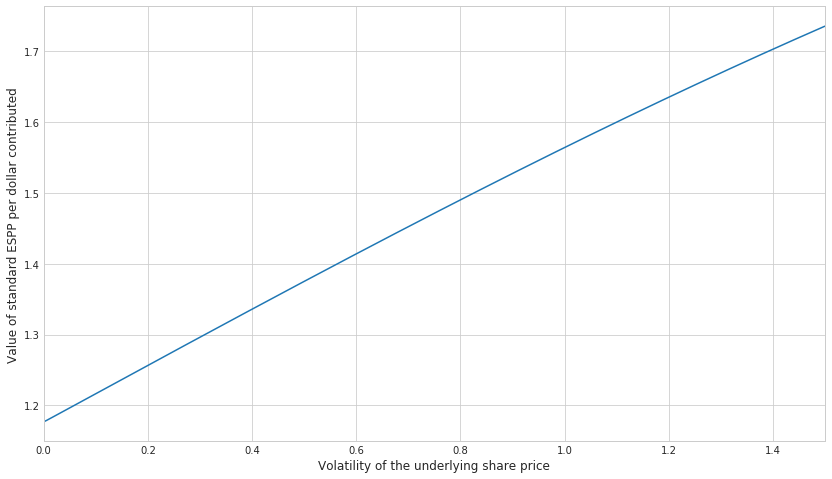

In [20]:
vget_standard_espp_return = np.vectorize(get_standard_espp_return, otypes=[np.float])

volatilities = np.linspace(0, 1.5, num=1000)

espp_returns = vget_standard_espp_return(volatilities)

fig = plt.figure(figsize=(14,8))
ax = plt.axes()
ax.set_xlabel('xlabel', fontsize=12)
ax.set_ylabel('ylabel', fontsize=12)

plt.plot(volatilities, espp_returns)

plt.xlim(0, 1.5)

plt.xlabel('Volatility of the underlying share price')
plt.ylabel('Value of standard ESPP per dollar contributed');

## Real life volatilities

We can now look at the volatilities of real life companies. I am using the standard ESPP from above. I have no idea what the ESPPs of any of these companies are, if they even have one. Any changes in the structure of ESPPs may make them more or less valuable.

In practice, we don't know what the volatility of a stock is and we have to estimate it. One way is to look at the historical volatility. Another way is to get the last price a particular option traded at. We can back out the implied probability from the Black-Scholes equation.

In [13]:
def get_implied_volatility(row, expiry_date, stock_price):
    option_value = row['Last Price']
    strike_price = row.Strike
    
    time_to_expiry = (parser.parse(expiry_date)-datetime.today()).days/365
    
    try:
        iv = implied_volatility(option_value, stock_price, strike_price, time_to_expiry, risk_free_rate, 'c')
    except:
        iv = np.float('nan')
    
    return iv

Let's look at the volatily of Apple stock, as implied by its call option chain.

In [14]:
ticker = 'AAPL'
stock_price = Stock(ticker).price
expiry_date = options.get_expiration_dates(ticker)[5]
call_options_chain = options.get_options_chain(ticker, expiry_date)['calls']

call_options_chain['Implied Volatility'] = call_options_chain.apply(get_implied_volatility, axis=1\
                                                                    , args=(expiry_date,stock_price))

call_options_chain.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,AAPL200626C00200000,2020-05-21 11:24AM EDT,200.0,116.70,0.00,0.00,0.0,-,1,0,NaN
1,AAPL200626C00220000,2020-05-20 3:46PM EDT,220.0,99.38,-,-,0.0,-,-,-,0.853174
2,AAPL200626C00225000,2020-05-20 3:53PM EDT,225.0,94.10,-,-,0.0,-,-,-,0.787590
3,AAPL200626C00230000,2020-05-20 3:56PM EDT,230.0,89.67,0.00,0.00,0.0,-,12,14,0.791196
4,AAPL200626C00235000,2020-05-20 3:58PM EDT,235.0,84.69,0.00,0.00,0.0,-,18,43,0.750804


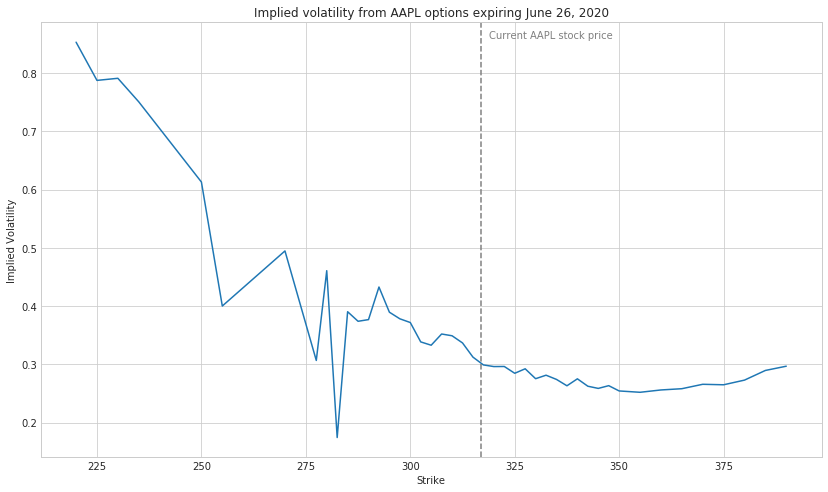

In [15]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes()

sns.lineplot(x='Strike', y='Implied Volatility', data=call_options_chain, ax=ax)
plt.axvline(x=stock_price, linestyle='--', c='grey')
plt.text(stock_price+2,0.86,'Current '+ticker+' stock price', c='grey')
plt.title('Implied volatility from AAPL options expiring '+expiry_date);

This U-shaped curve is the so-called volatility smile. This makes it harder to estimate what the value of an ESPP is since the way it is set up it accepts a constant volatility. I will choose the implied volatility for the option with the strike price closest to the current stock price.

From the graph, this is not the lowest point on the volatility smile, but it is not far off.

I will also choose the nearest option chain expiring closest to one year from today.

In [16]:
def stock_implied_volatility(ticker):
    stock_price = Stock(ticker).price
    expiry_dates = options.get_expiration_dates(ticker)
    expiry_dates_dt = [parser.parse(date) for date in expiry_dates]
    today_plus_one_year = datetime.today()+relativedelta.relativedelta(years=1)

    nearest_expiry_date_index = min(range(len(expiry_dates_dt))\
                                    , key=lambda i: abs((today_plus_one_year-expiry_dates_dt[i]).days))

    nearest_expiry_date = expiry_dates[nearest_expiry_date_index]

    call_options_chain = options.get_options_chain(ticker, nearest_expiry_date)['calls']

    call_options_chain['Implied Volatility'] = call_options_chain.apply(get_implied_volatility, axis=1,\
                                                                        args=(nearest_expiry_date,stock_price))
    
    #call_options_chain = call_options_chain[~call_options_chain['Implied Volatility'].isna()]
    
    chosen_call_option = call_options_chain.iloc[(call_options_chain['Strike']-stock_price).abs().argsort()[0]]

    implied_volatility = chosen_call_option['Implied Volatility']

    return implied_volatility

Let's now plot what a standard ESPP is worth for some well known companies

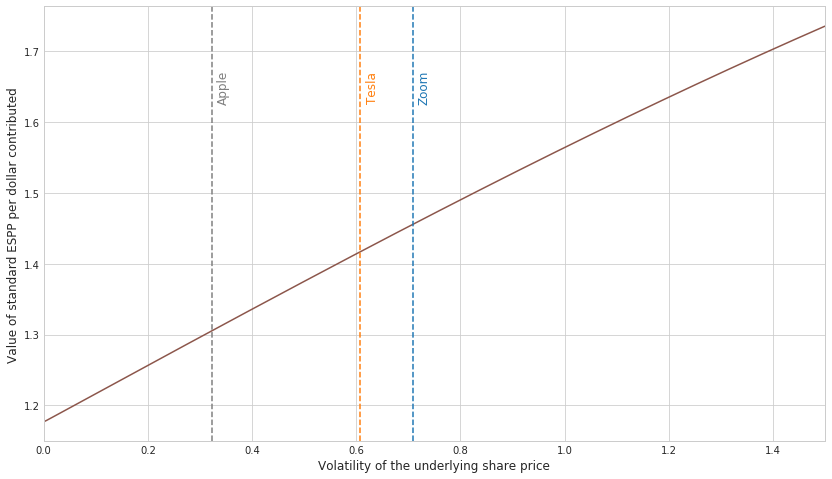

In [19]:
tickers = ['AAPL', 'ZM', 'TSLA']
names = ['Apple', 'Zoom', 'Tesla']
colors = ['tab:gray', 'tab:blue', 'tab:orange']

volatilities = np.linspace(0, 1.5, num=1000)

espp_returns = vget_standard_espp_return(volatilities)

fig = plt.figure(figsize=(14,8))
ax = plt.axes()
ax.set_xlabel('xlabel', fontsize=12)
ax.set_ylabel('ylabel', fontsize=12)

plt.plot(volatilities, espp_returns, c='tab:brown')

plt.xlim(0, 1.5)

plt.xlabel('Volatility of the underlying share price')
plt.ylabel('Value of standard ESPP per dollar contributed');

for ticker, name, color in zip(tickers, names, colors):
    iv = stock_implied_volatility(ticker)
    plt.axvline(x=iv, linestyle='--', c=color)
    plt.text(iv+0.01, 1.65, name, rotation=90, verticalalignment='center',c=color, fontsize=12)